In [1463]:
# !pip install ../input/pytorchlightning/fastremap-1.10.2-cp37-cp37m-manylinux1_x86_64.whl
# !pip install ../input/pytorchlightning/fill_voids-2.0.0-cp37-cp37m-manylinux1_x86_64.whl
# !pip install ../input/johof-lungmask/lungmask

import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from plotly.offline import init_notebook_mode
from lungmask import mask, resunet
import SimpleITK as sitk
import torch

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline
init_notebook_mode(connected=True)


# Set Color Palettes for the notebook (https://color.adobe.com/)
colors_nude = ['#FFE61A','#B2125F','#FF007B','#14B4CC','#099CB3']

# Set Style
sns.set_style("whitegrid")

# Config

In [1464]:
#### Defining constants and loading data
USE_PICKLED_DATA_TRAIN = True
USE_PICKLED_DATA_TEST = True
N_ITERATIONS = 500
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/"
PICKLE_INPUT_DIR = 'Pickle'
# PICKLE_INPUT_DIR = "../input/torch-pickle-train/"
PICKLE_OUTPUT_DIR = "Pickle"
R231_PATH = "../input/unet-models/models/unet_r231-d5d2fc3d.pth"
LTCR_LOBES_PATH = "../input/unet-models/models/unet_ltrclobes-3a07043d.pth"

try:
    os.makedirs(PICKLE_OUTPUT_DIR)
    print("Directory " , PICKLE_OUTPUT_DIR ,  " Created ")
except:
    print("Directory " , PICKLE_OUTPUT_DIR ,  " creation failed")

test_pickle_path = PICKLE_INPUT_DIR + "/testing_df_unique_patients_ct.pkl"
train_pickle_path = PICKLE_INPUT_DIR + "/training_df_unique_patients_ct.pkl"

df_train = pd.read_csv(IMAGE_PATH + 'train.csv')
df_test = pd.read_csv(IMAGE_PATH + 'test.csv')
df_train["dcm_path"] = IMAGE_PATH + "train/" + df_train.Patient + "/"
df_test["dcm_path"] = IMAGE_PATH + "train/" + df_test.Patient + "/"

Directory  Pickle  creation failed


# Functions

In [1465]:
def cat_to_binary(value, cat_name):
    if value == cat_name:
        return 1
    else:
        return 0

def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    try:
        sd_clipped = np.maximum(confidence, 70)
        delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
        metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

        if return_values:
            return metric
        else:
            return np.mean(metric)
    except:
        print('Could not calculate LLL')
        return 0

def calculate_gradient_coef_for_patient(patient_records_df):
    X_train = patient_records_df[['Weeks']]
    y_train = patient_records_df[['FVC']]
    try:
        model = LinearRegression(normalize=True).fit(X_train, y_train)
        return model.coef_[0][0]
    except:
        print('Could not fit LinearRegression model')
        return 0

def prepare_patient_data(df_raw, patient_id, df_new):
    try:
        # Filter by single patients
        patient_records_df = df_raw[df_raw.Patient == patient_id]
        number_records = len(patient_records_df)
        gradient_coef = calculate_gradient_coef_for_patient(patient_records_df)
        max_fvc = patient_records_df[['FVC']].max()[0]
        min_fvc = patient_records_df[['FVC']].min()[0]
        std_fvc = patient_records_df[['FVC']].std()[0]
        if np.isnan(std_fvc):
            std_fvc = 0

        first_measurement = patient_records_df.iloc[0]
        last_measurement = patient_records_df.iloc[number_records - 1]
        diff_abs_fvc = last_measurement['FVC'] - first_measurement['FVC']
        # print('L {} - F {} = {}'.format(last_measurement['FVC'], first_measurement['FVC'], diff_abs_fvc))
        df_unique_patient = pd.DataFrame(
            index=[patient_id],
            columns=[
                'FVC_First',
                'FVC_Last',
                'Diff_FVC_Abs',
                'Gradient_Coef',
                'Max_FVC',
                'Min_FVC',
                'Std_FVC'
            ],
            data=[[
                first_measurement['FVC'],
                last_measurement['FVC'],
                diff_abs_fvc,
                gradient_coef,
                max_fvc,
                min_fvc,
                std_fvc]]
        )
        df_unique_patient['First_Week'] = first_measurement['Weeks']
        df_unique_patient['Percent'] = first_measurement['Percent']
        df_unique_patient['Age'] = first_measurement['Age']
        df_unique_patient['Sex'] = first_measurement['Sex']
        df_unique_patient['SmokingStatus'] = first_measurement['SmokingStatus']
        df_unique_patient['dcm_path'] = first_measurement['dcm_path']
        df_unique_patient['Male'] = cat_to_binary(first_measurement['Sex'], 'Male')
        df_unique_patient['Female'] = cat_to_binary(first_measurement['Sex'], 'Female')
        df_unique_patient['NeverSmoked'] = cat_to_binary(first_measurement['SmokingStatus'], 'Never smoked')
        df_unique_patient['ExSmoker'] = cat_to_binary(first_measurement['SmokingStatus'], 'Ex-smoker')
        df_unique_patient['CurrentlySmokes'] = cat_to_binary(first_measurement['SmokingStatus'], 'Currently smokes')
        df_unique_patient['lung_volume_cm3'] = 0
        df_unique_patient['percentage_fibrotic_tissue'] = 0

        df_new = df_new.append(df_unique_patient)
        return df_new
    except:
        print('Could not prepare patient data for patient {}'.format(patient_id))
        return df_new

def prepare_unique_patients_train_df(df_train):
    try:
        df_unique_patients = pd.DataFrame(
            columns=[
                'First_Week',
                'FVC_First',
                'FVC_Last',
                'Diff_FVC_Abs',
                'Gradient_Coef',
                'Max_FVC',
                'Min_FVC',
                'Std_FVC',
                'Percent',
                'Age',
                'Sex',
                'SmokingStatus',
                'dcm_path',
                'Male',
                'Female',
                'NeverSmoked',
                'ExSmoker',
                'CurrentlySmokes',
                'lung_volume_cm3',
                'percentage_fibrotic_tissue'
            ])
        unique_patient_ids = df_train['Patient'].unique()
        for patient_id in unique_patient_ids:
            df_unique_patients = prepare_patient_data(df_train, patient_id, df_unique_patients)
        return df_unique_patients
    except:
        print('Could not prepare unique patients dataframe')
        return None

def prepare_unique_patients_test_df(df_test):
    try:
        df_test = df_test.set_index('Patient')
        df_test['Male'] = df_test.apply (lambda x: cat_to_binary(x['Sex'], 'Male'), axis=1)
        df_test['Female'] = df_test.apply (lambda x: cat_to_binary(x['Sex'], 'Female'), axis=1)
        df_test['NeverSmoked'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Never smoked'), axis=1)
        df_test['ExSmoker'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Ex-smoker'), axis=1)
        df_test['CurrentlySmokes'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Currently smokes'), axis=1)
        df_test['lung_volume_cm3'] = 0
        df_test['percentage_fibrotic_tissue'] = 0
        return df_test
    except:
        print('Could not prepare test unique patients dataframe')
        return None

def prepare_boosting_data_x(df_unique_patients: pd.DataFrame):
    # Prepare unique patients an make them suitable for gradient boosting model
    df_copy = df_unique_patients.copy()
    try:
        x = df_copy[[
            'Percent',
            'Age',
            'Male',
            'Female',
            'NeverSmoked',
            'ExSmoker',
            'CurrentlySmokes',
            'lung_volume_cm3',
            'percentage_fibrotic_tissue'
        ]].to_numpy()

        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        return  x_scaled
    except:
        calculate_public_board_lll(df_test, df_train, create_debug_submission(df_test, 2000, 800))
        print('Could not prepare boosting data x')
        return None

def prepare_boosting_data_y(df_unique_patients: pd.DataFrame):
    try:
        df_copy = df_unique_patients.copy()
        df_copy.dropna(inplace=True)
        return df_copy[['Gradient_Coef']].values.ravel()
    except:
        print('Could not prepare boosting data y')
        return None

def test_boost_performance(df_train: pd.DataFrame, test_patients, mean_std_fvc, std_dev_multiplier = 5):
    """
    Create test submission values to check LLL on test split
    Takes in the coefficients of the test group of the boost model split and calculates LLL based on the
    full df_train with all measurements
    :param df_train: All train measurements of all patients. Is needed to get all measurements of the
                        test candidates
    :param test_patients: A patient dataframe (unique patients) from the test split
    :param y_test_predicted: Linear gradient coefficients for each test patient
    """
    test_patient_ids = list(test_patients.index.values)
    df_test_patient_measurements = df_train[df_train.Patient.isin(test_patient_ids)]
    lll_total = 0

    for index, row in df_test_patient_measurements.iterrows():
        week = row['Weeks']
        first_measurement = test_patients.loc[row.Patient]
        patient_id = row['Patient']
        patient_sample_fvc = first_measurement['FVC_First']
        patient_sample_week = first_measurement['First_Week']
        coef_predicted = first_measurement['Gradient_Predicted']
        predicted_fvc = np.round(patient_sample_fvc + (week - patient_sample_week) * coef_predicted, 0)
        std_dev = np.round(mean_std_fvc * std_dev_multiplier * np.abs(week - patient_sample_week) / 145)
        lll = laplace_log_likelihood(row['FVC'], predicted_fvc, std_dev)
        # print('{} FVC real: {} FVC predicted: {} StdDev: {} LLL: {}'.format(patient_id, row['FVC'], predicted_fvc, std_dev, lll))
        lll_total += lll
    return lll_total / len(df_test_patient_measurements)

def calculate_public_board_lll(df_test, df_train, df_submission):
    try:
        test_patient_ids = list(df_test['Patient'])
        last_n_results = 7
        lll_total = 0
        predicted_fvc = 0
        for patient_id in test_patient_ids:
            df_patient = df_train[df_train['Patient'] == patient_id].tail(last_n_results)
            for index, row in df_patient.iterrows():
                week = row['Weeks']
                predicted_fvc = float(df_submission.loc[df_submission['Patient_Week'] == patient_id + '_' + str(week)]['FVC'].values[0])
                confidence = float(df_submission.loc[df_submission['Patient_Week'] == patient_id + '_' + str(week)]['Confidence'].values[0])
                lll = laplace_log_likelihood(row['FVC'], predicted_fvc, confidence, return_values = True)
                lll_total += lll
        print('Public Board LLL', predicted_fvc, lll_total / (len(test_patient_ids) * last_n_results))
    except:
        print('Error on calculating public board LLL')

def create_debug_submission(df_raw, fvc, confidence):
    weeks = range(-12, 134, 1)
    arr = np.empty((0,3), int)

    for i in range(len(df_raw)):
        for week in weeks:
            patient_week = df_raw.at[i, 'Patient'] + '_' + str(week)
            arr = np.append(arr, np.array([[patient_week, fvc, confidence]]), axis=0)

    df_submission = pd.DataFrame(arr, columns=['Patient_Week', 'FVC', 'Confidence'])
    df_submission.to_csv('submission.csv', index=False)
    return df_submission

def create_linear_decay_submission(df_raw, coef_predicted, mean_std, std_dev_multiplier, filename='test_submission'):
    weeks = range(-12, 134, 1)
    arr = np.empty((0,3), int)
    df_raw = df_raw.fillna(value=1)

    for i in range(len(df_raw)):
        try:
            if isinstance(coef_predicted, float):
                coef = coef_predicted
            else:
                coef = float(coef_predicted[i])
        except:
            pass
        for week in weeks:
            try:
                patient_week = df_raw.at[i, 'Patient'] + '_' + str(week)
            except:
                print('Except 1')
                patient_week = 0
            try:
                patient_sample_fvc = df_raw.at[i, 'FVC']
            except:
                print('Except 2')
                patient_sample_fvc = 0
            try:
                patient_sample_week = df_raw.at[i, 'Weeks']
            except:
                print('Except 3')
                patient_sample_week = 0
            try:
                predicted_fvc = int(np.round(patient_sample_fvc + (week - patient_sample_week) * coef,0))
                if predicted_fvc < 0:
                    predicted_fvc = 0
            except:
                print('Except 4')
                predicted_fvc = 0
            try:
                # std_dev = int(np.round(mean_std * std_dev_multiplier * np.abs(week - patient_sample_week) / 145))
                std_dev = int(np.round(70 + np.abs(week - patient_sample_week) * 1000 / (145 - patient_sample_week)))
                if std_dev < 0:
                    std_dev = 0
            except:
                print('Except 5')
                std_dev = 0
            try:
                arr = np.append(arr, np.array([[patient_week, predicted_fvc, std_dev]]), axis=0)
            except:
                print('Except 6')

    df_submission = pd.DataFrame(arr, columns=['Patient_Week', 'FVC', 'Confidence'])

    try:
       df_submission.to_csv(filename + '.csv', index=False)
    except:
       print('could not create CSV file')

    return df_submission

def iterate_patient_cts(df_unique_patients, prefix: str, patient_dir='train'):
    i = 0
    for index, row in df_unique_patients.iterrows():
        if i > N_ITERATIONS - 1:
            break
        try:
            lung_volume_cm3 = get_lung_volume_torch(row['dcm_path'])
            lung_volume_without_fibrotic_cm3 = get_lung_volume_torch(row['dcm_path'], 'LTRCLobes')
            fibrotic_volume_cm3 = max(lung_volume_cm3 - lung_volume_without_fibrotic_cm3, 0)

            if not lung_volume_cm3 or not fibrotic_volume_cm3:
                lung_volume_cm3 = 1
                fibrotic_volume_cm3 = 1
            print('CT Result:', i, index, lung_volume_cm3, fibrotic_volume_cm3)
            df_unique_patients.loc[index,'lung_volume_cm3'] = lung_volume_cm3
            df_unique_patients.loc[index,'percentage_fibrotic_tissue'] = fibrotic_volume_cm3 / lung_volume_cm3
        except:
            i += 1
            continue
        i += 1
    try:
        df_unique_patients.to_pickle(PICKLE_OUTPUT_DIR + "/{}_df_unique_patients_ct.pkl".format(prefix), protocol=2)
    except:
        print('Could not save to pickle')
    return df_unique_patients

def set_manual_window(hu_image, custom_center, custom_width):
    w_image = hu_image.copy()
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    w_image[w_image < min_value] = min_value
    w_image[w_image > max_value] = max_value
    return w_image

def load_model(name='R231'):
    model = None
    if name == 'R231':
        model = resunet.UNet(n_classes=3, padding=True, depth=5, up_mode='upsample', batch_norm=True, residual=False)
        model.load_state_dict(torch.load(R231_PATH, map_location=torch.device('cpu')))
    if name == 'LTRCLobes':
        model = resunet.UNet(n_classes=6, padding=True, depth=5, up_mode='upsample', batch_norm=True, residual=False)
        model.load_state_dict(torch.load(LTCR_LOBES_PATH, map_location=torch.device('cpu')))
    model.eval()
    return model

def get_lung_volume_torch(dcm_path: str, model_name='R231'):
    # LTRCLobes model for volume without fibrotic tissue
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dcm_path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    size = image.GetSize()
    length, width, height = image.GetSpacing()
    pixel_volume = length * width * height
    print("Image size:", size[0], size[1], size[2], 'Spacing:', image.GetSpacing(), 'Pixel volume:', pixel_volume)

    # model = mask.get_model('unet', model_name)
    model = load_model(model_name)
    segmentation = mask.apply(image, model)
    lung_pixels = np.count_nonzero(segmentation)
    lung_volume_cm3 = pixel_volume * lung_pixels / 1000
    print('Lung volume cm3:', lung_volume_cm3 , 'all lung pixels', lung_pixels)
    return lung_volume_cm3

def clean_outliers(df_unique_patients: pd.DataFrame, dataset='train'):
    fvc_key = 'Max_FVC'
    if dataset == 'test':
        fvc_key = 'FVC'
    #### Cleaning data lung volume
    df_unique_patients["lung_volume_cm3_raw"] = df_unique_patients["lung_volume_cm3"]

    # set all patients with a picture lung volume > 2000 cm³ over their max FVC to their max FVC (lung way too big)
    df_unique_patients.loc[df_unique_patients["lung_volume_cm3_raw"] > df_unique_patients[fvc_key] + 2000, "lung_volume_cm3"] \
        = df_unique_patients.loc[df_unique_patients["lung_volume_cm3_raw"] > df_unique_patients[fvc_key] + 2000][fvc_key]

    # set all patients with a picture lung volume smaller than their max FVC to their max FVC (lung way too small)
    df_unique_patients.loc[df_unique_patients["lung_volume_cm3_raw"] < df_unique_patients[fvc_key], "lung_volume_cm3"] \
        = df_unique_patients.loc[df_unique_patients["lung_volume_cm3_raw"] < df_unique_patients[fvc_key]][fvc_key]

    # set all patients with NaN lung_volume_cm3 to their Max FVC
    df_unique_patients.loc[df_unique_patients["lung_volume_cm3_raw"].isna(), "lung_volume_cm3"] \
        = df_unique_patients.loc[df_unique_patients["lung_volume_cm3_raw"].isna()][fvc_key]

    # clean NaN rows
    df_unique_patients = df_unique_patients[~df_unique_patients.isin([np.nan, np.inf, -np.inf]).any(1)]
    df_unique_patients.dropna(inplace=True)


    #### Cleaning data lung fibrotic tissue
    MAX_FIBROTIC_TISSUE_ALLOWED = 0.07
    df_unique_patients["percentage_fibrotic_tissue_raw"] = df_unique_patients["percentage_fibrotic_tissue"]
    print('mean', df_unique_patients[df_unique_patients["percentage_fibrotic_tissue_raw"] < MAX_FIBROTIC_TISSUE_ALLOWED]["percentage_fibrotic_tissue_raw"].median())
    df_unique_patients.loc[df_unique_patients["percentage_fibrotic_tissue_raw"] > MAX_FIBROTIC_TISSUE_ALLOWED, "percentage_fibrotic_tissue"] \
        = df_unique_patients[df_unique_patients["percentage_fibrotic_tissue_raw"] < MAX_FIBROTIC_TISSUE_ALLOWED]["percentage_fibrotic_tissue_raw"].median()

    return df_unique_patients

# Loading data

In [1466]:
if USE_PICKLED_DATA_TRAIN:
    df_unique_patients = pd.read_pickle(train_pickle_path)
else:
    df_unique_patients = prepare_unique_patients_train_df(df_train)
    df_unique_patients = iterate_patient_cts(df_unique_patients, 'training', 'train')

if USE_PICKLED_DATA_TEST:
    df_unique_patients_test = pd.read_pickle(test_pickle_path)
else:
    df_unique_patients_test = prepare_unique_patients_test_df(df_test)
    df_unique_patients_test = iterate_patient_cts(df_unique_patients_test, 'testing', 'test')

# Cleaning data

In [1467]:
df_unique_patients = clean_outliers(df_unique_patients, 'train')
df_unique_patients_test = clean_outliers(df_unique_patients_test, 'test')

mean 0.022332326529950437
mean 0.027825126686738984


<AxesSubplot:xlabel='lung_volume_cm3'>

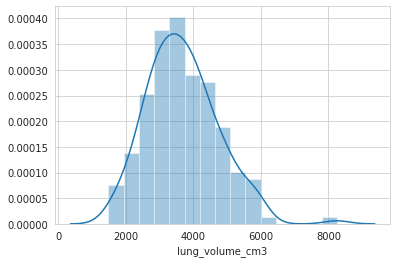

In [1468]:
sns.distplot(df_unique_patients["lung_volume_cm3"])

<AxesSubplot:xlabel='percentage_fibrotic_tissue'>

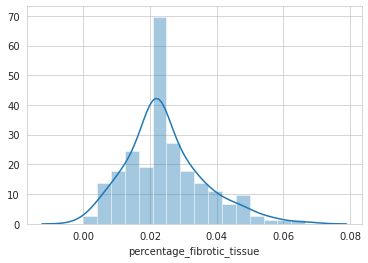

In [1469]:
sns.distplot(df_unique_patients["percentage_fibrotic_tissue"])

In [1470]:
df_unique_patients[["Max_FVC", "lung_volume_cm3", "percentage_fibrotic_tissue"]].head(20)

Max_FVC lung_volume_cm3 percentage_fibrotic_tissue
ID00007637202177411956430    2315          3708.5                  0.0588281
ID00009637202177434476278    3895         4886.81                  0.0155793
ID00010637202177584971671    3523            3523                  0.0365305
ID00011637202177653955184    3541          4691.4                  0.0145222
ID00012637202177665765362    3759         4497.16                  0.0257102
ID00014637202177757139317    3897            3897                  0.0223323
ID00015637202177877247924    3120         4301.61                  0.0238683
ID00019637202178323708467    2116         3288.57                   0.020964
ID00020637202178344345685    2297         2731.41                  0.0207825
ID00023637202179104603099    1681         2615.86                   0.031605
ID00025637202179541264076    3277         3906.97                  0.0214694
ID00026637202179561894768    3007            3007                  0.0223323
ID00027637202179689871102    2887            2887                  0.0223323
ID00030637202181211009029    2694         3154.53                  0.0398265
ID00032637202181710233084    5045            5045                   0.027095
ID00035637202182204917484    2787         3633.47                  0.0268284
ID00038637202182690843176    4000         5895.77                  0.0107351
ID00042637202184406822975    3961          4043.3                  0.0220151
ID00047637202184938901501    3370         4469.03                  0.0152966
ID00048637202185016727717    1477          1485.9                  0.0223323

# Gradient boosting
## Setup

In [1471]:
#### Prepare train datasets for training
df_unique_patients.dropna(inplace=True)
train_patients, test_patients = train_test_split(df_unique_patients, test_size=0.2)

# #### Set up gradient boosting model and train
X_train = prepare_boosting_data_x(train_patients)
y_train = prepare_boosting_data_y(train_patients)
X_test = prepare_boosting_data_x(test_patients)
y_test = prepare_boosting_data_y(test_patients)

params = {'n_estimators': 50,
          'max_depth': 3,
          'min_samples_split': 10,
          'learning_rate': 0.01,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)

#### Train gradient boosting model
try:
    reg.fit(X_train, y_train)
    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(scores)
    print("MSE mean over k folds in training set: %0.2f" % (scores.mean()))

except:
    print('Could not fit GradientBoostingRegressor')

y_test_predicted = None
try:
    y_test_predicted = reg.predict(X_test)
except:
    print('Could not predict y test')
mse = mean_squared_error(y_test, y_test_predicted)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

X_test_submit = prepare_boosting_data_x(df_unique_patients_test)
coef_predicted_submission = None

try:
    coef_predicted_submission = reg.predict(X_test_submit)
except:
    print('Coef for submission could not be predicted')
print(coef_predicted_submission)

[-42.56132174 -38.13252626 -47.72406367 -30.64821746 -52.0430598 ]
MSE mean over k folds in training set: -42.22
The mean squared error (MSE) on test set: 21.1117
[ -4.60189194  -0.86027721  -4.34663022 -11.3930363   -4.92798105]


## Create submission files

In [1472]:
#### Create submission files
mean_std_fvc = df_unique_patients.Std_FVC.mean()
print(mean_std_fvc)
std_dev_multiplier = 19
df_submission = create_linear_decay_submission(
    df_test, coef_predicted_submission, mean_std_fvc, std_dev_multiplier, "submission")
calculate_public_board_lll(df_test, df_train, df_submission)

154.8115965322575
Public Board LLL 2634.0 -7.193882541632827


## Create test submission files

In [1473]:
#### Reduce train dataframe to one (first) measurement per patient only
df_train_only_first_entry = df_train.drop_duplicates(subset='Patient', keep="first")
df_train_only_first_entry.reset_index(inplace=True)
df_train_only_first_entry.head()
#### Get predictions for all train patients
X_all_train = prepare_boosting_data_x(df_unique_patients)
coef_predicted_all_train = None
try:
    coef_predicted_all_train = reg.predict(X_all_train)
except:
    print('Coef for all train could not be predicted')
print(coef_predicted_all_train)

#### Create submission files for all training patients
df_submission_train = create_linear_decay_submission(
    df_train_only_first_entry,
    coef_predicted_all_train,
    mean_std_fvc,
    std_dev_multiplier,
    'submission_train')
calculate_public_board_lll(df_test, df_train, df_submission_train)

[ -4.34663022  -4.92798105  -4.92798105  -4.92798105  -4.92798105
  -5.20982375  -4.92798105  -4.92798105  -4.92798105  -4.92798105
  -4.92798105  -4.92798105  -4.92798105  -4.92798105  -4.92798105
  -4.92798105  -4.92798105  -4.92798105  -4.92798105  -4.92798105
  -4.92798105 -11.674879    -4.92798105  -4.92798105  -4.92798105
  -4.92798105  -4.92798105  -4.92798105  -4.92798105  -5.20982375
  -0.34587246  -4.92798105  -5.20982375  -2.08682436  -4.92798105
  -4.92798105  -4.92798105  -4.92798105  -4.92798105  -4.92798105
  -4.92798105  -4.92798105  -4.92798105  -4.92798105  -4.92798105
  -4.92798105  -4.92798105  -4.92798105  -2.08682436  -4.92798105
  -4.92798105  -4.92798105  -3.69608286  -4.60189194  -4.92798105
  -5.20982375  -4.92798105  -4.92798105  -4.92798105  -4.92798105
  -4.92798105  -4.92798105  -4.92798105  -3.69608286  -4.92798105
  -4.92798105  -4.92798105  -2.08682436  -4.92798105  -4.92798105
  -4.69541901  -4.92798105  -4.92798105  -4.92798105  -4.92798105
  -4.92798

In [1474]:
#### Test submission values on LLL for gradient boost
test_patients.insert(2, 'Gradient_Predicted', y_test_predicted)
lll_total = -100
multiplier_max = 0
for std_dev_multiplier in range(0,20):
    lll_total_new = test_boost_performance(df_train, test_patients, mean_std_fvc, std_dev_multiplier)
    #print(lll_total_new)
    if lll_total_new > lll_total:
        lll_total = lll_total_new
        multiplier_max = std_dev_multiplier
print('LLL for test split is {} for std dev multiplier of {}'.format(lll_total, multiplier_max))
df_submission_test_2 = create_linear_decay_submission(df_test, coef_predicted_submission, mean_std_fvc, std_dev_multiplier, "submission_test_2")
calculate_public_board_lll(df_test, df_train, df_submission_test_2)

LLL for test split is -6.721953216571656 for std dev multiplier of 18
Public Board LLL 2634.0 -7.193882541632827


# EDA

In [1475]:
# print('Length cleaned Dataframe:', len(df_unique_patients))
# sns.scatterplot(x='percentage_fibrotic_tissue', y='Percent',data=df_unique_patients)
# plt.show()

In [1476]:
# sns.scatterplot(x='percentage_fibrotic_tissue', y='Gradient_Coef',data=df_unique_patients)
# plt.show()


In [1477]:
# sns.scatterplot(x='Percent', y='Gradient_Coef',data=df_unique_patients)
# plt.show()

In [1478]:
# df_unique_patients.head(3)

In [1479]:
# sns.distplot(df_unique_patients.lung_volume_cm3)

In [1480]:
# sns.distplot(df_unique_patients.Gradient_Coef)

In [1481]:
# sns.distplot(df_unique_patients.percentage_fibrotic_tissue, bins=10)
# plt.show()

In [1482]:
# df_modified = df_unique_patients.copy()
# sns.scatterplot(x='lung_volume_cm3', y='Max_FVC' ,data=df_modified, marker="+")
# plt.show()

ID00007637202177411956430
ID00009637202177434476278
ID00010637202177584971671
ID00011637202177653955184
ID00012637202177665765362
ID00014637202177757139317
ID00015637202177877247924
ID00019637202178323708467
ID00020637202178344345685
ID00023637202179104603099
ID00025637202179541264076
ID00026637202179561894768
ID00027637202179689871102
ID00030637202181211009029
ID00032637202181710233084
ID00035637202182204917484
ID00038637202182690843176
ID00042637202184406822975
ID00047637202184938901501
ID00048637202185016727717
ID00051637202185848464638
ID00052637202186188008618
ID00060637202187965290703
ID00061637202188184085559
ID00062637202188654068490
ID00067637202189903532242
ID00068637202190879923934
ID00072637202198161894406
ID00073637202198167792918
ID00075637202198610425520
ID00076637202199015035026
ID00077637202199102000916
ID00078637202199415319443
ID00082637202201836229724
ID00086637202203494931510
ID00089637202204675567570
ID00090637202204766623410
ID00093637202205278167493
ID0009463720

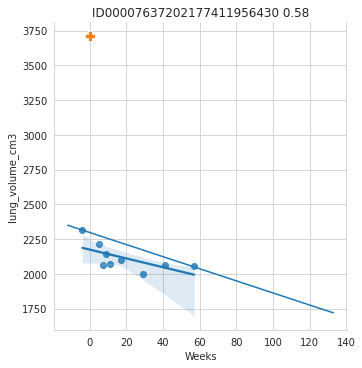

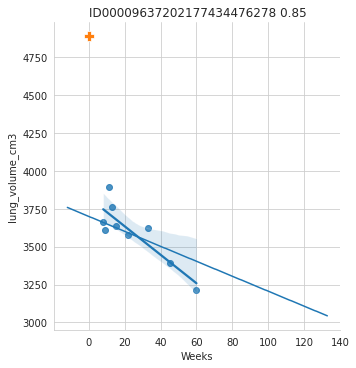

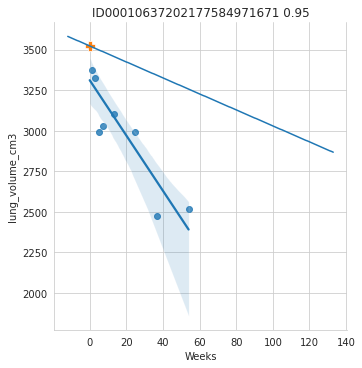

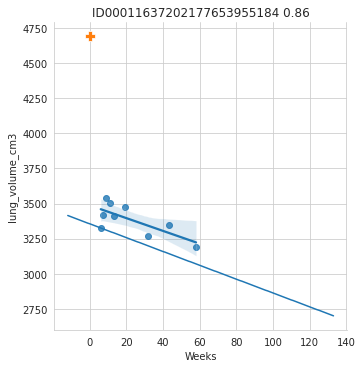

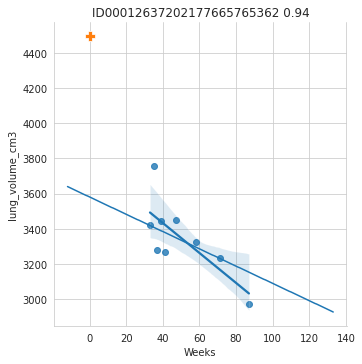

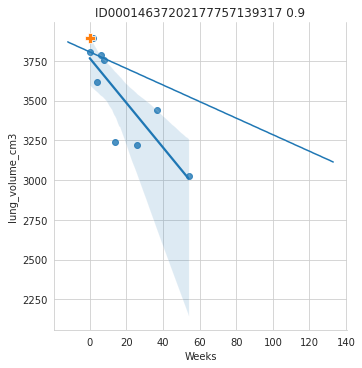

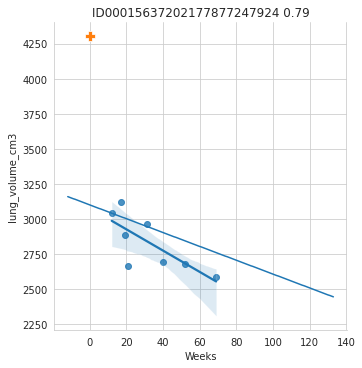

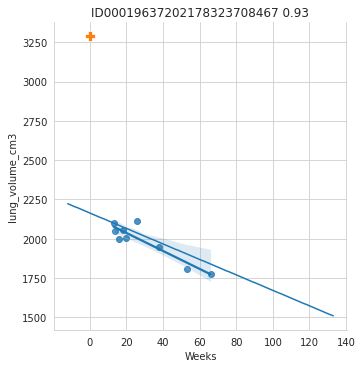

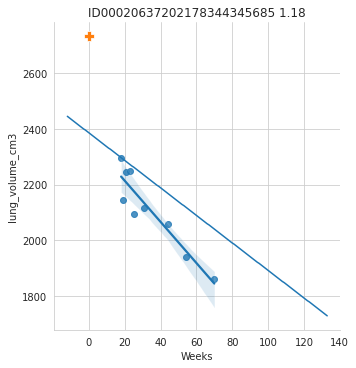

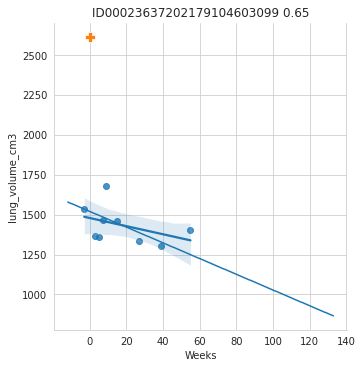

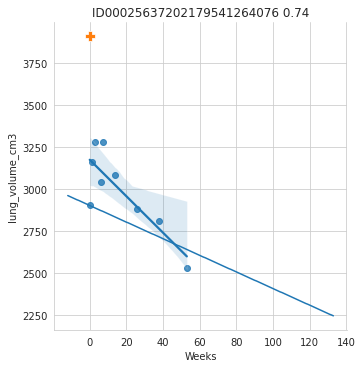

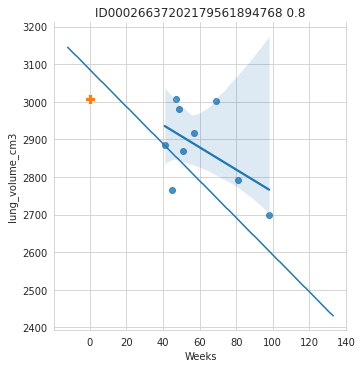

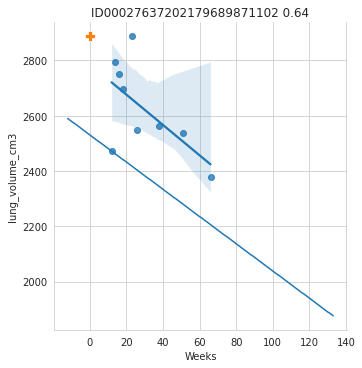

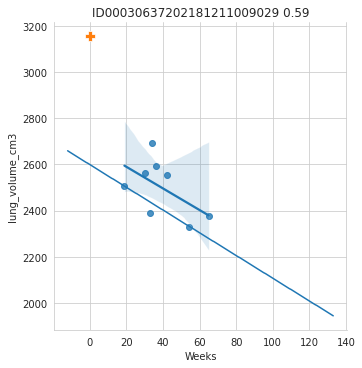

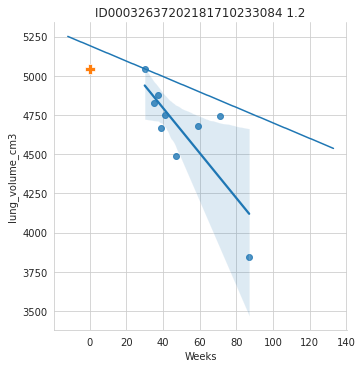

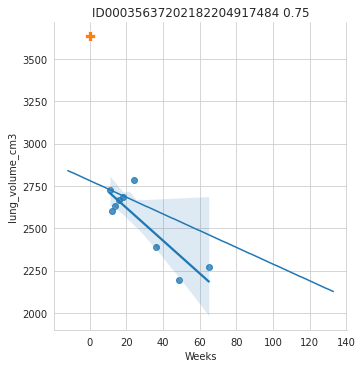

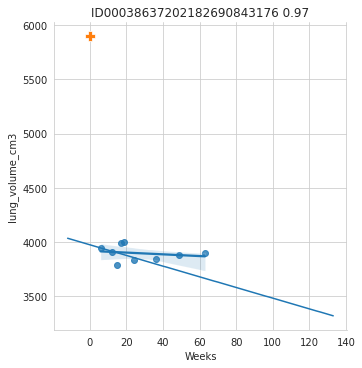

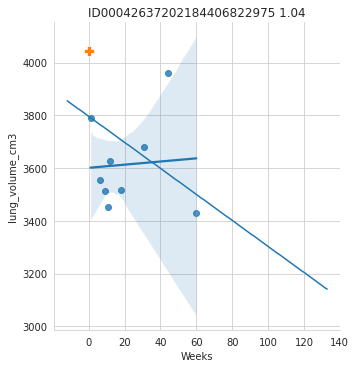

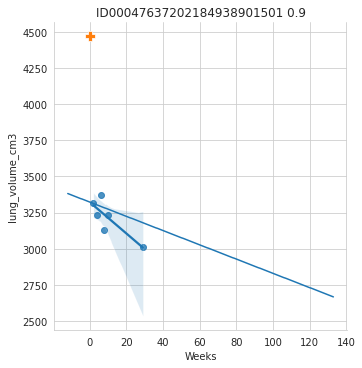

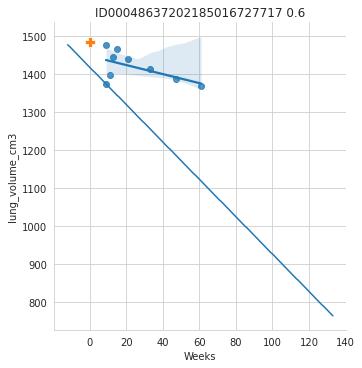

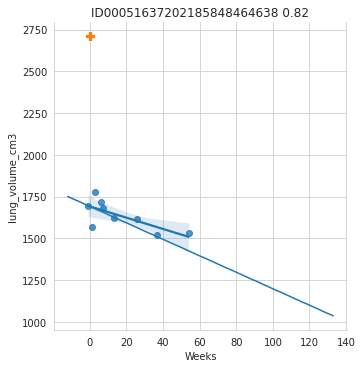

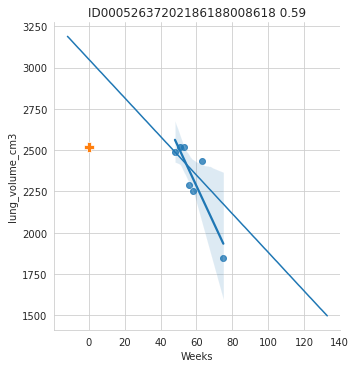

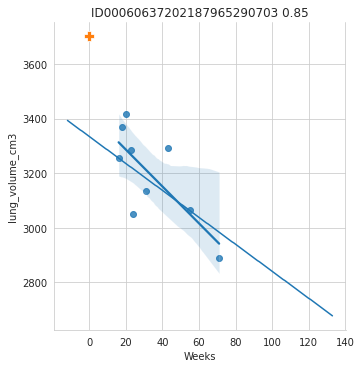

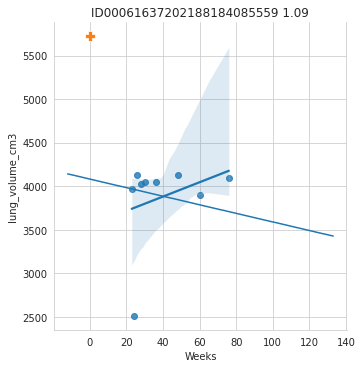

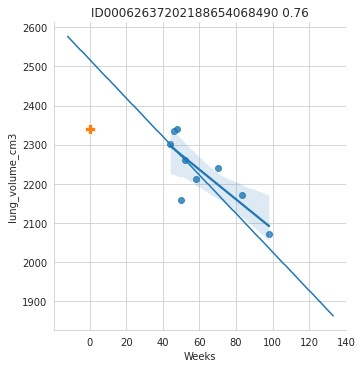

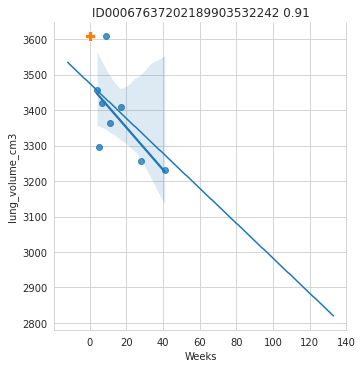

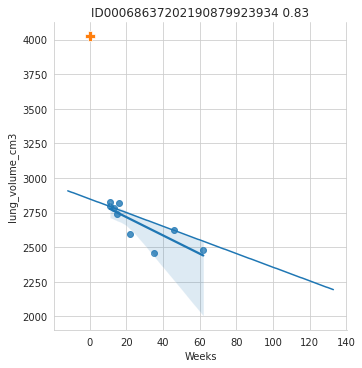

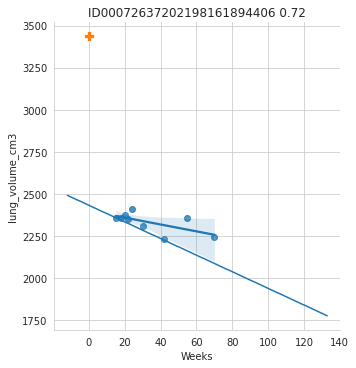

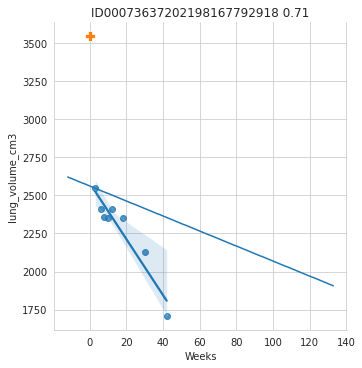

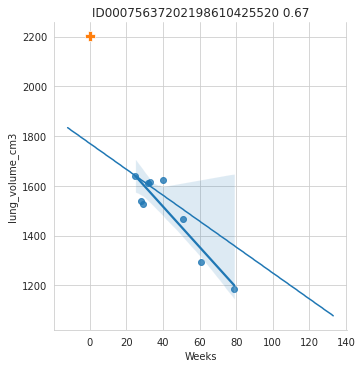

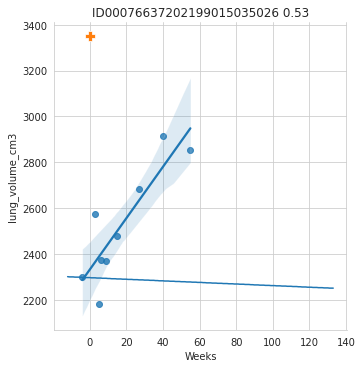

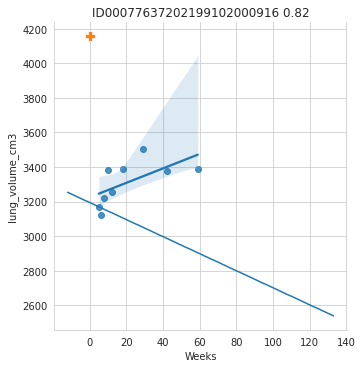

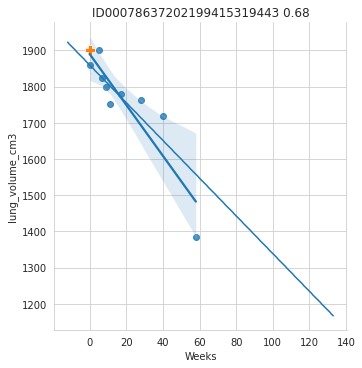

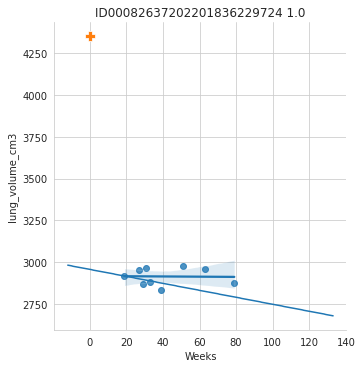

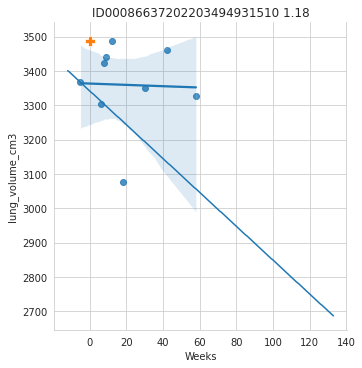

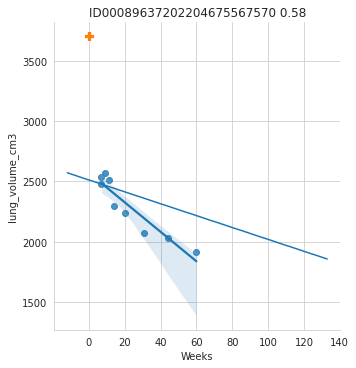

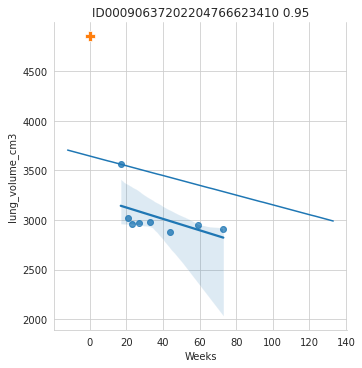

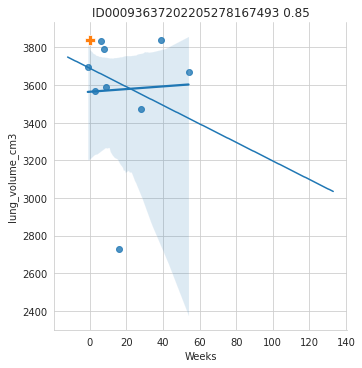

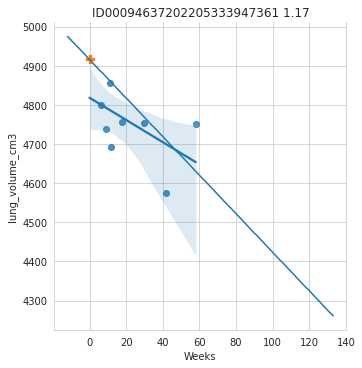

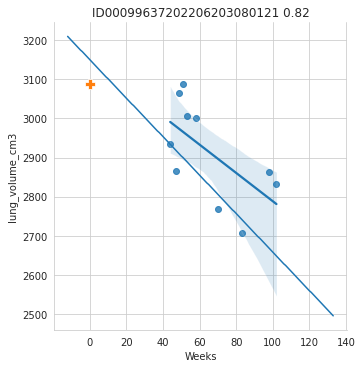

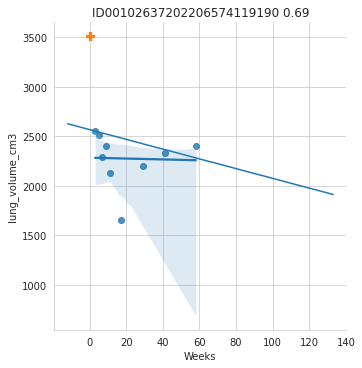

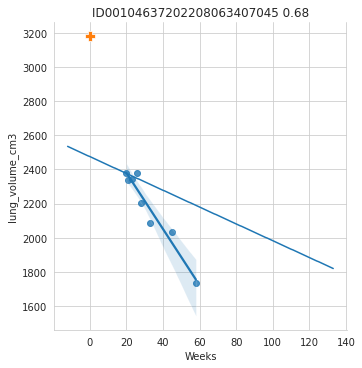

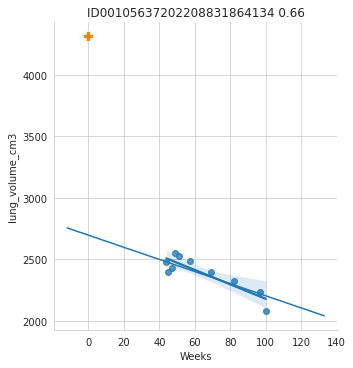

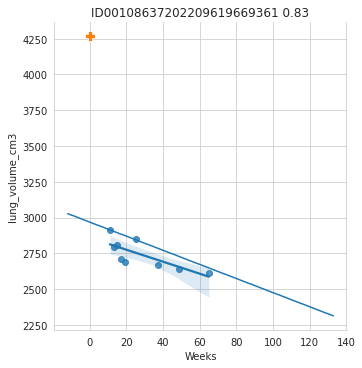

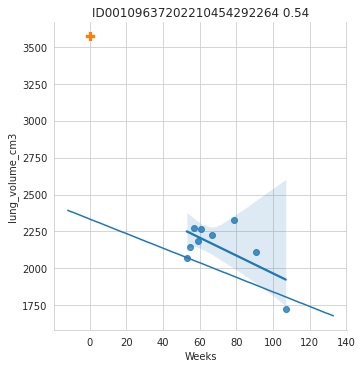

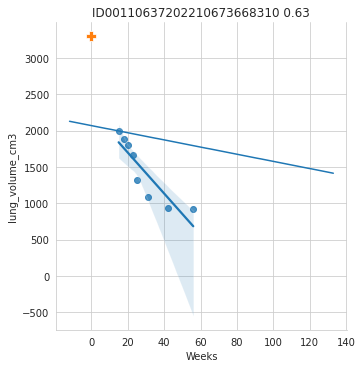

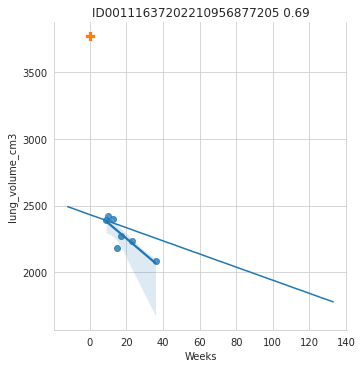

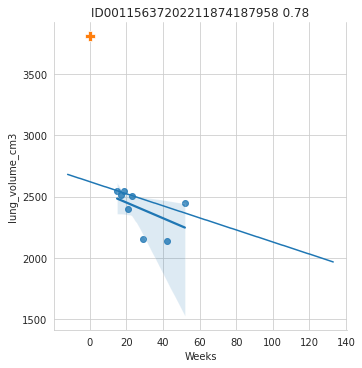

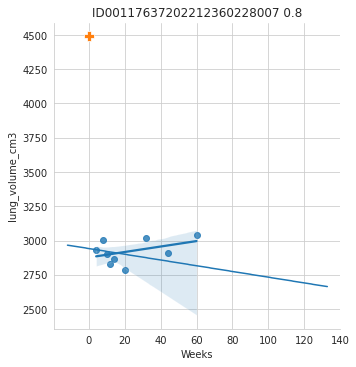

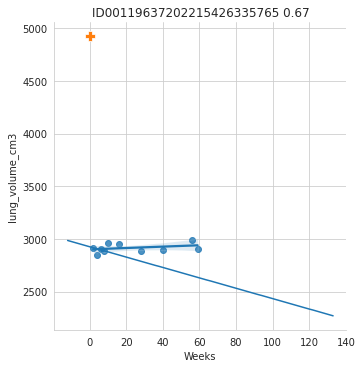

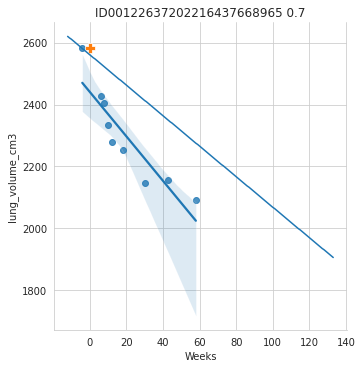

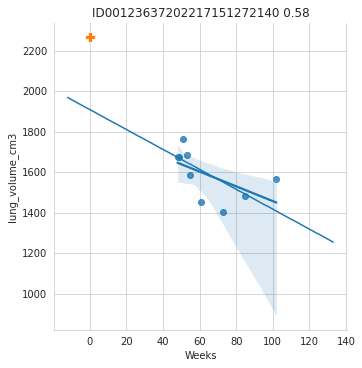

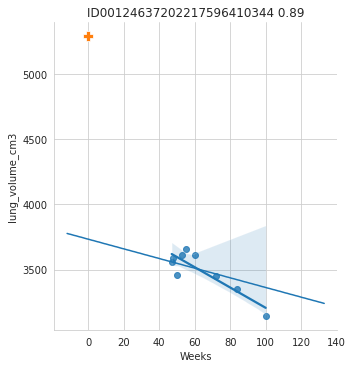

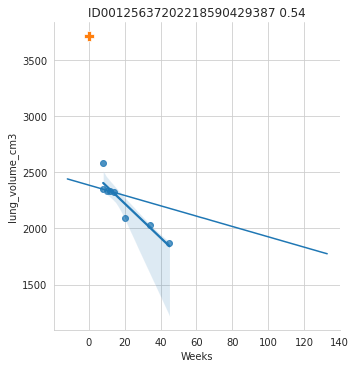

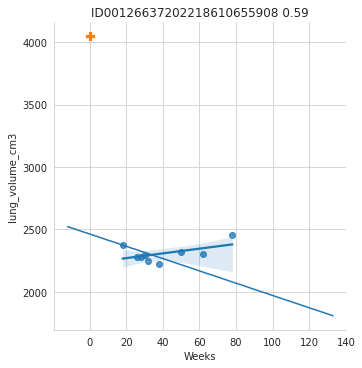

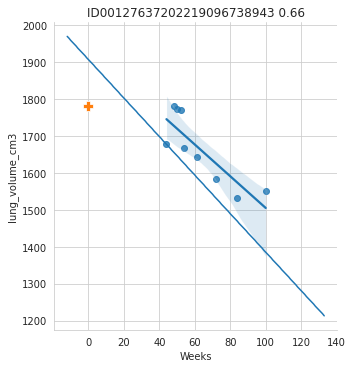

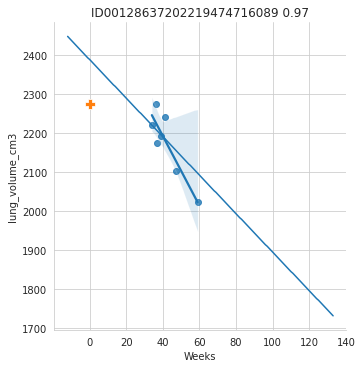

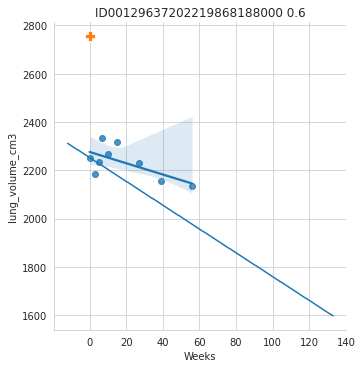

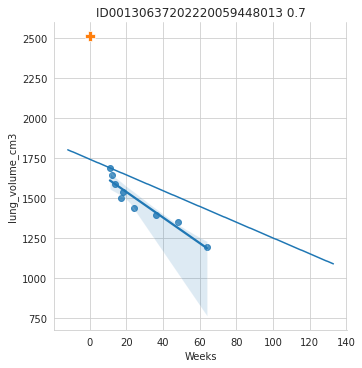

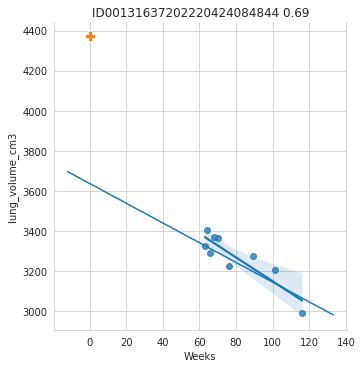

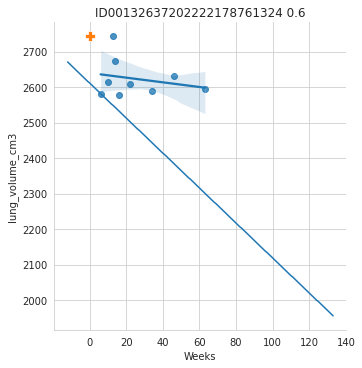

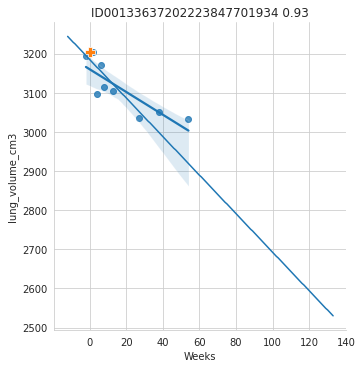

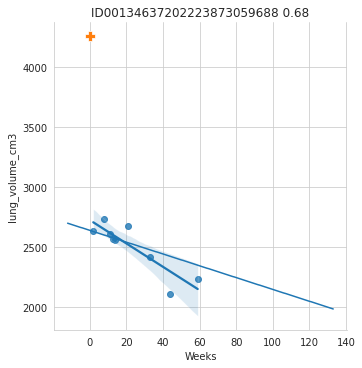

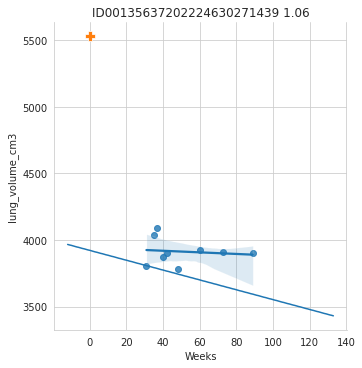

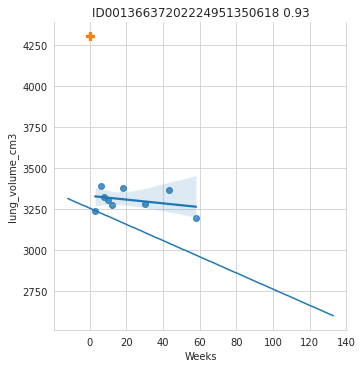

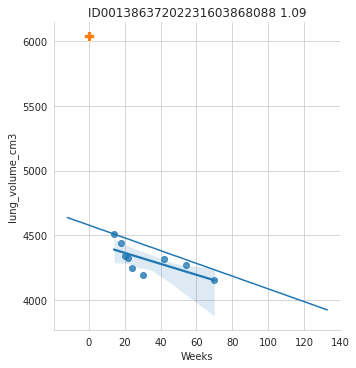

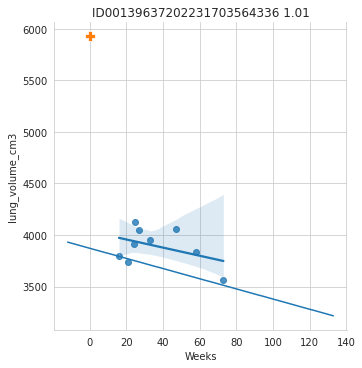

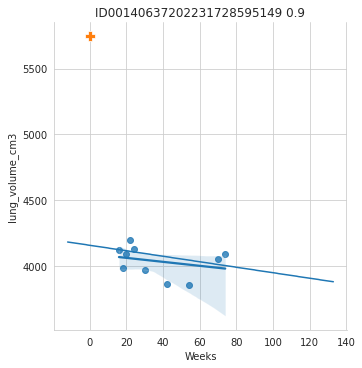

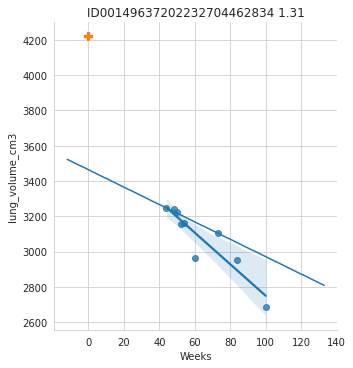

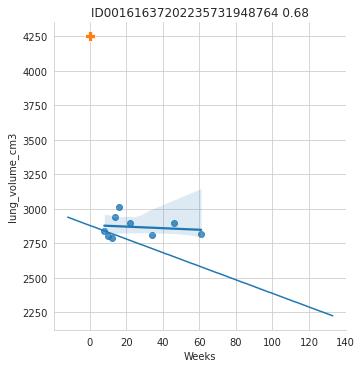

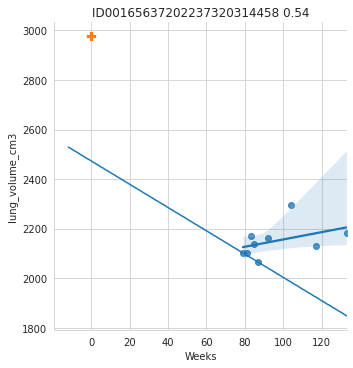

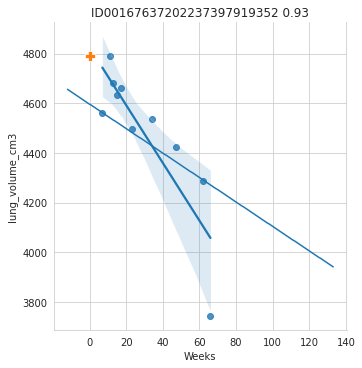

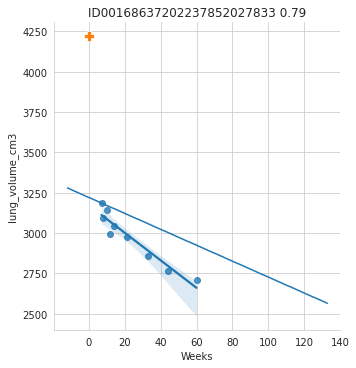

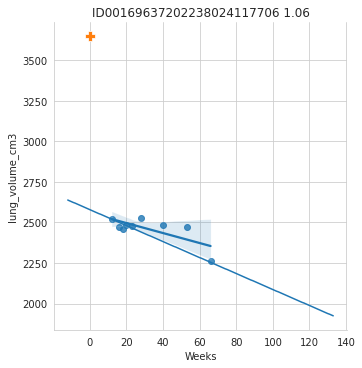

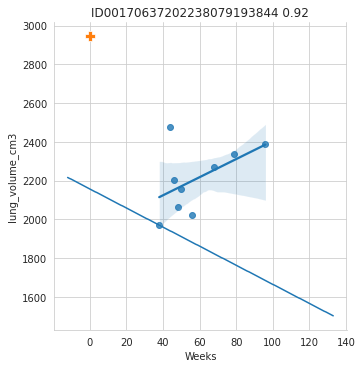

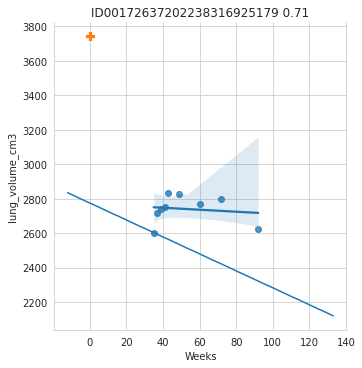

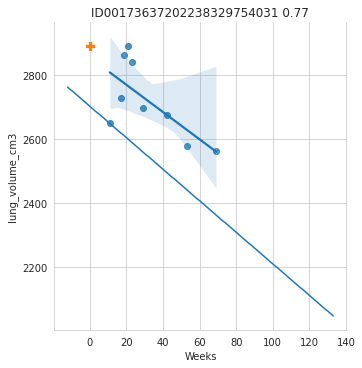

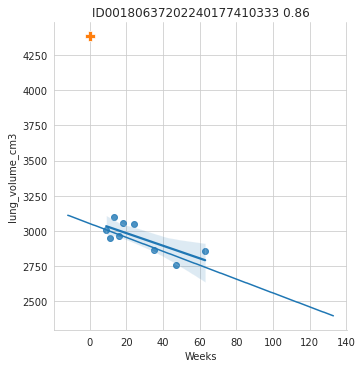

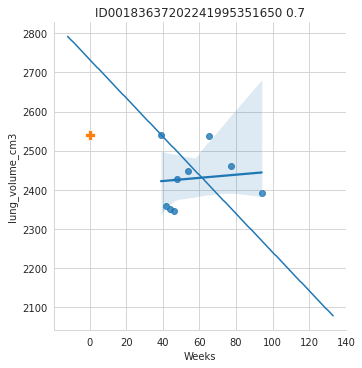

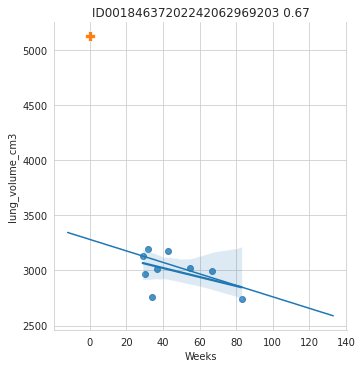

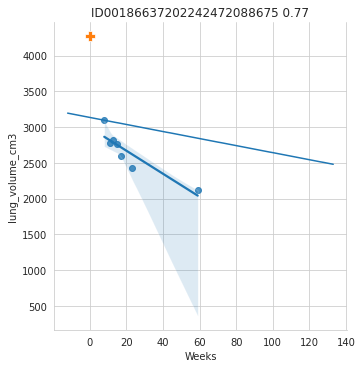

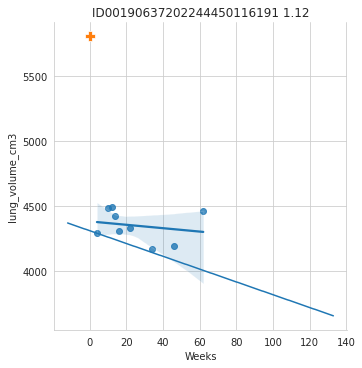

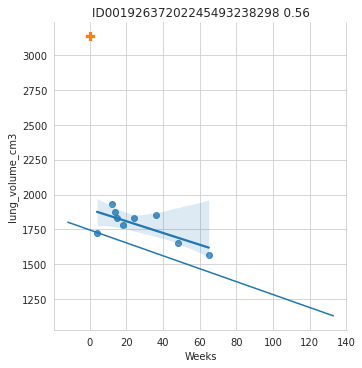

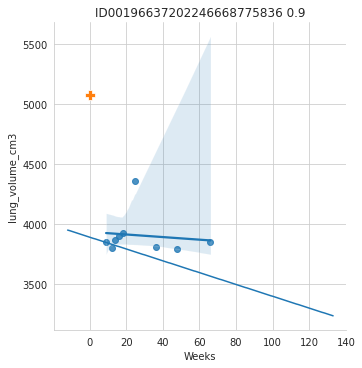

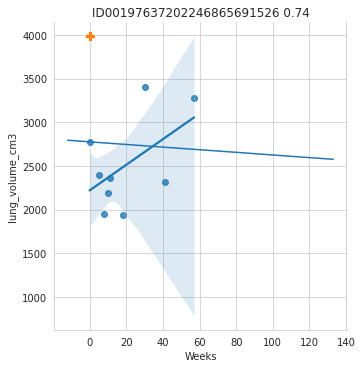

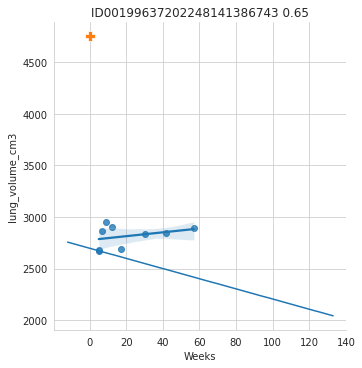

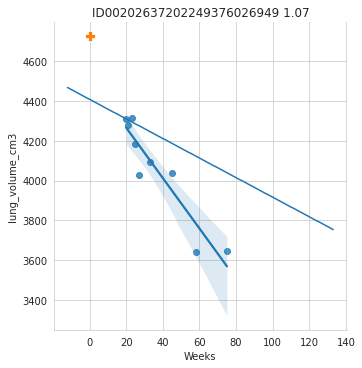

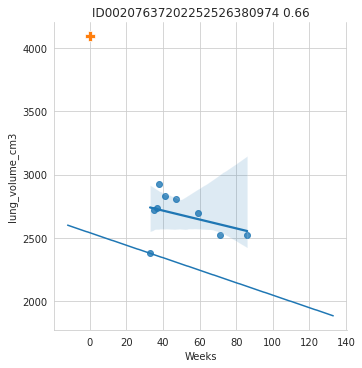

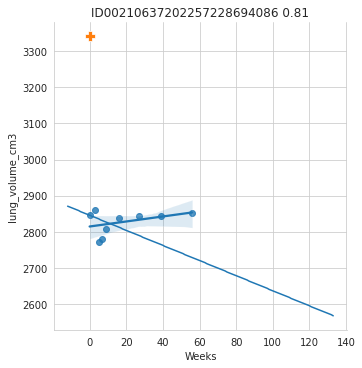

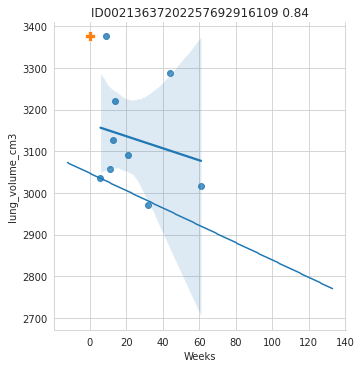

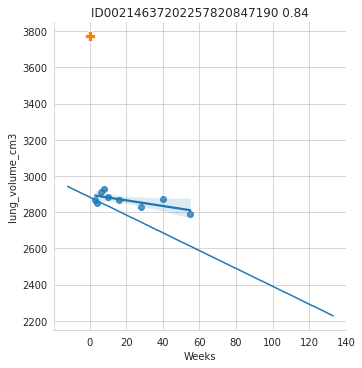

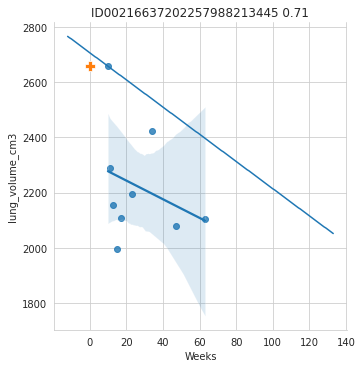

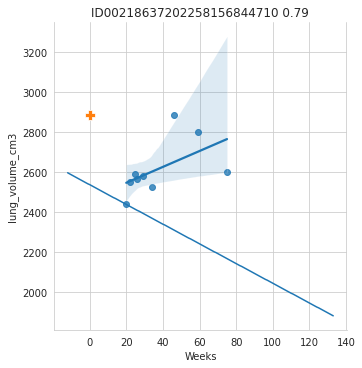

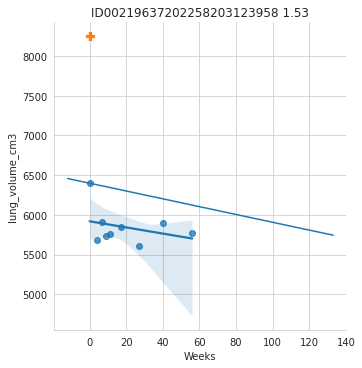

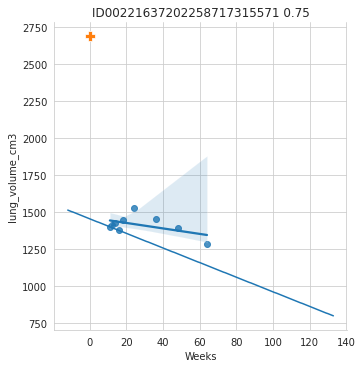

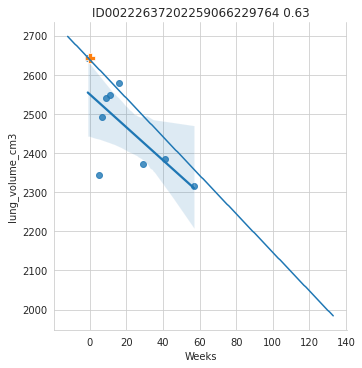

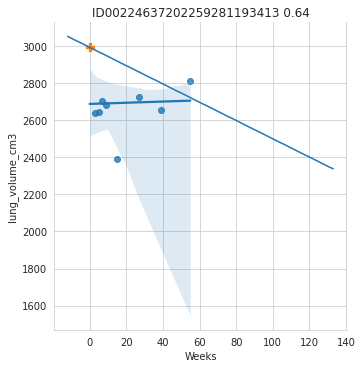

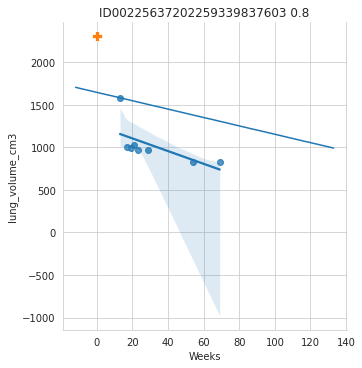

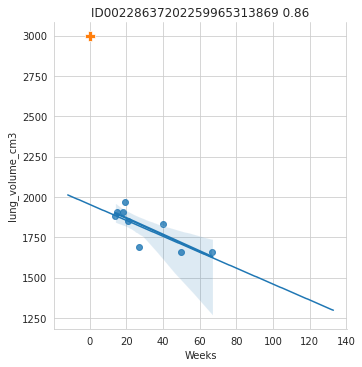

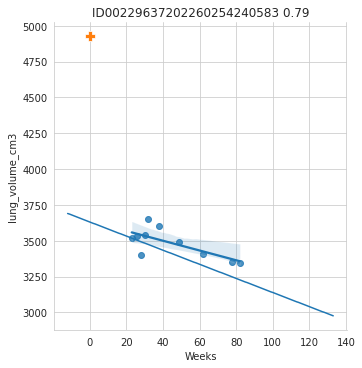

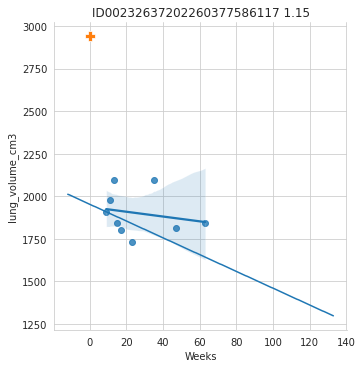

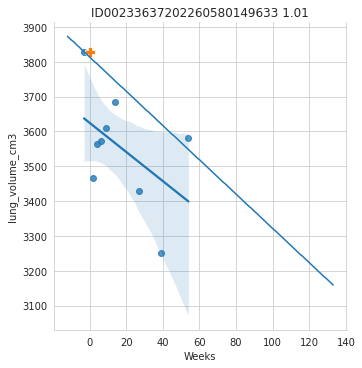

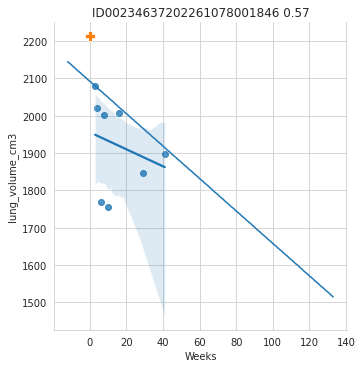

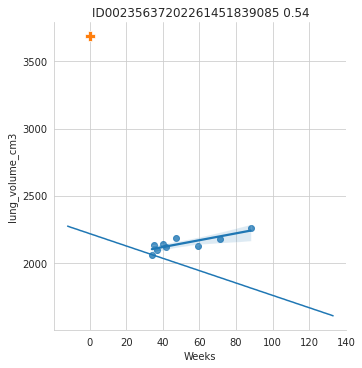

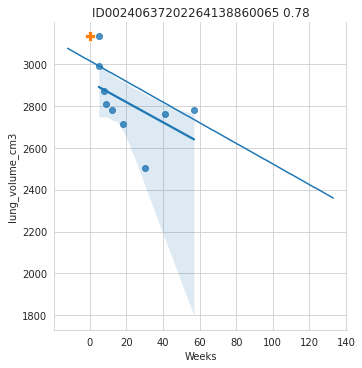

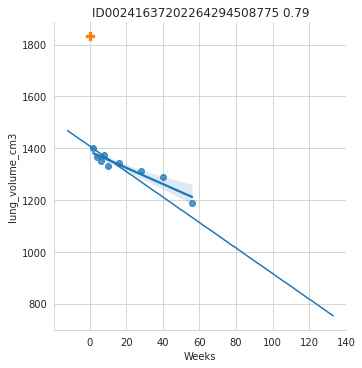

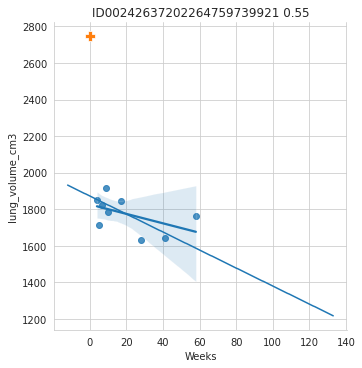

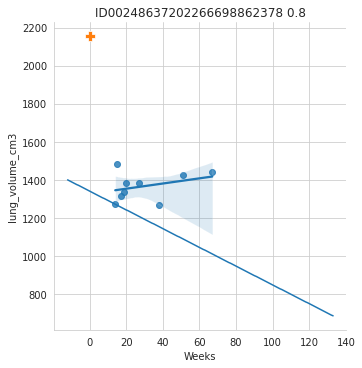

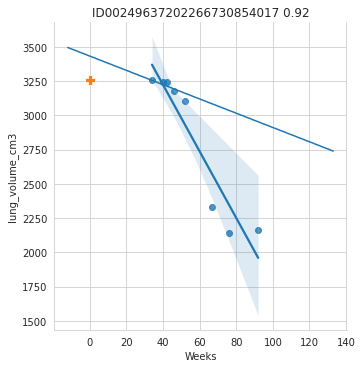

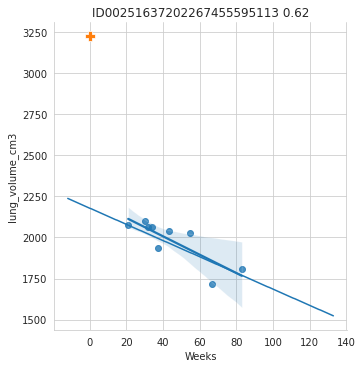

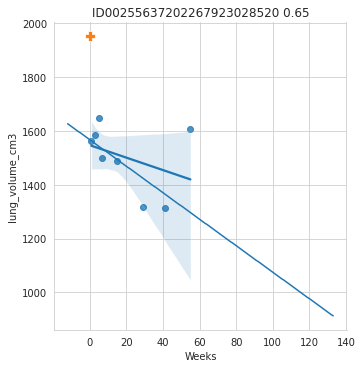

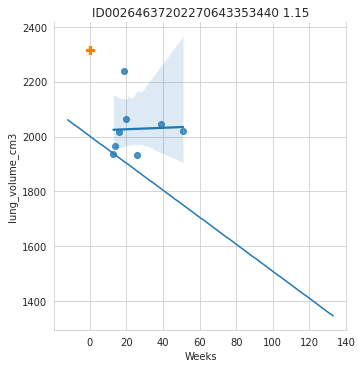

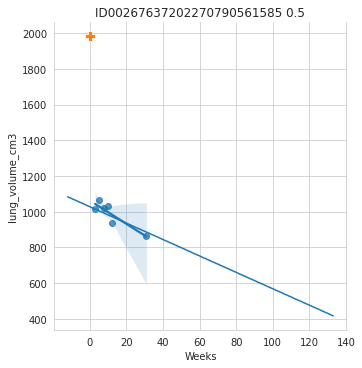

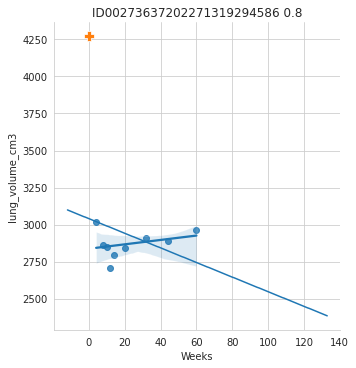

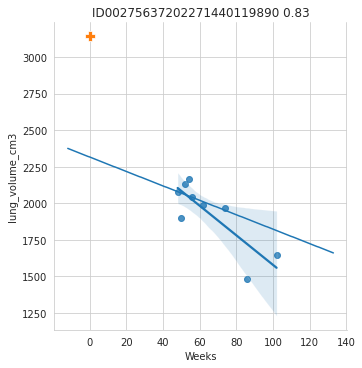

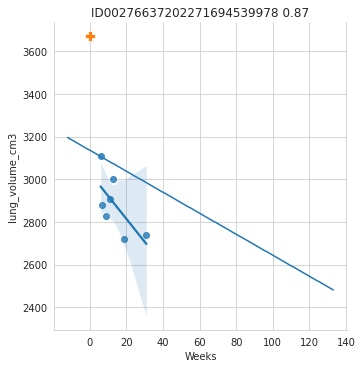

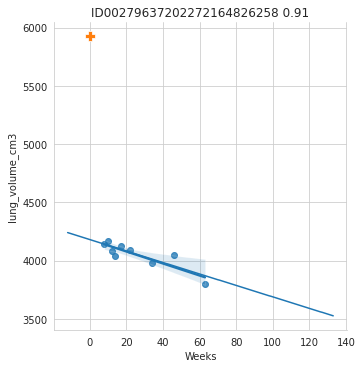

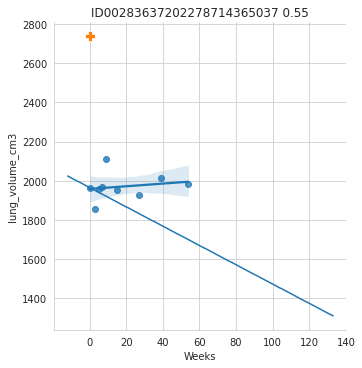

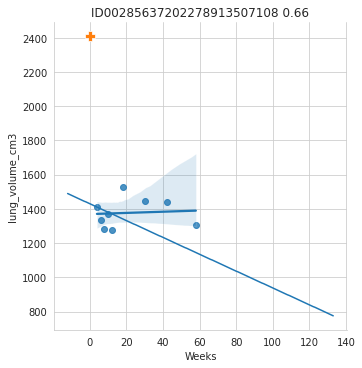

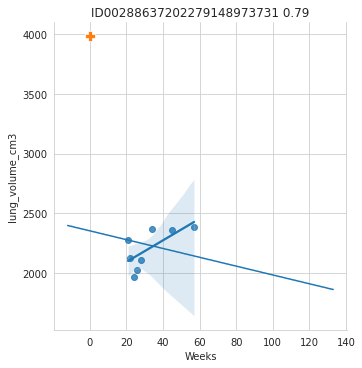

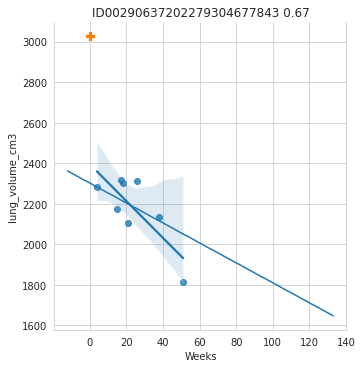

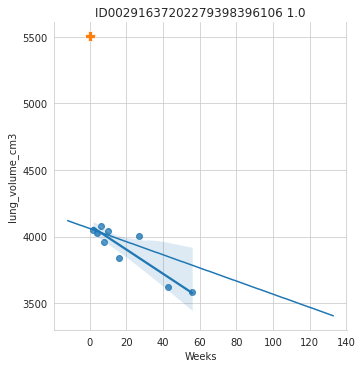

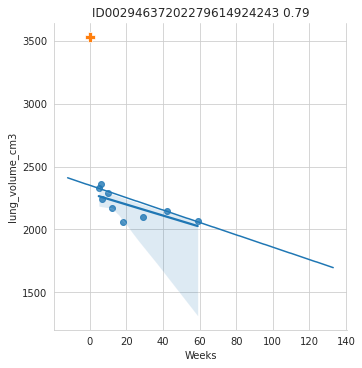

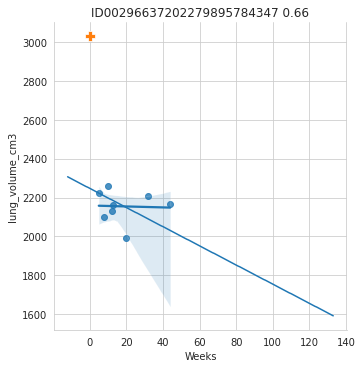

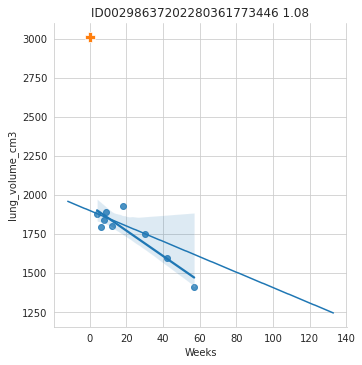

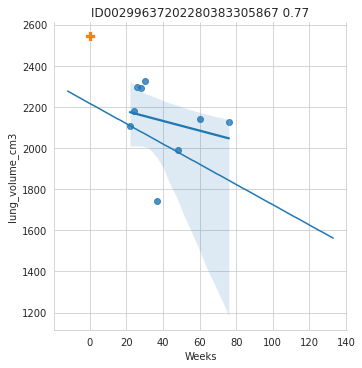

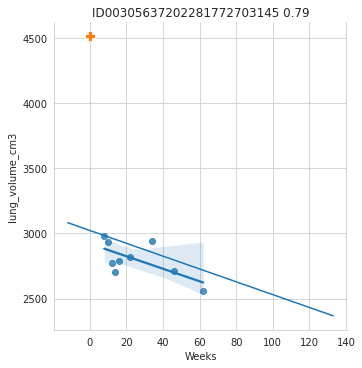

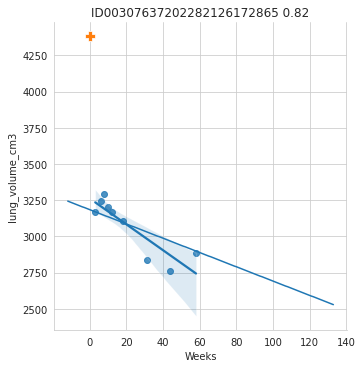

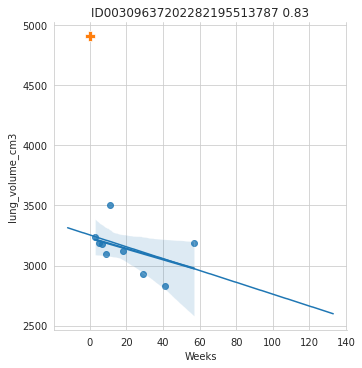

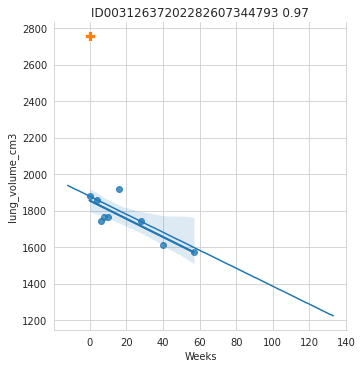

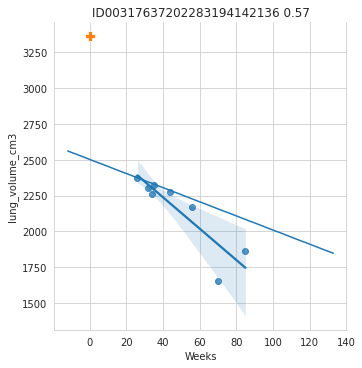

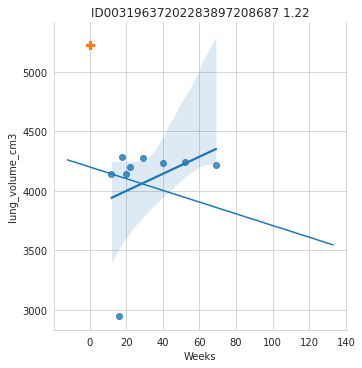

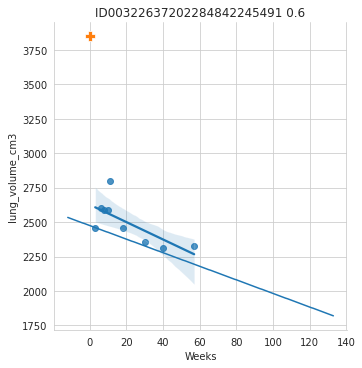

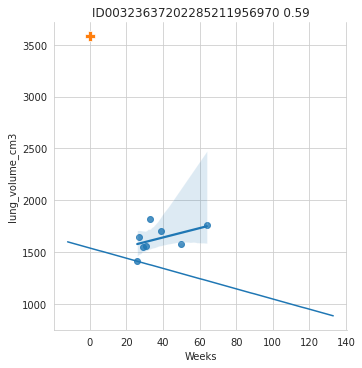

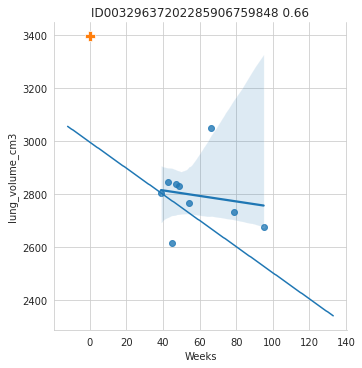

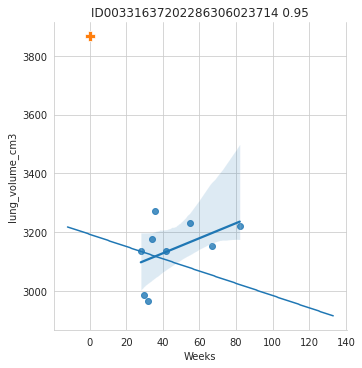

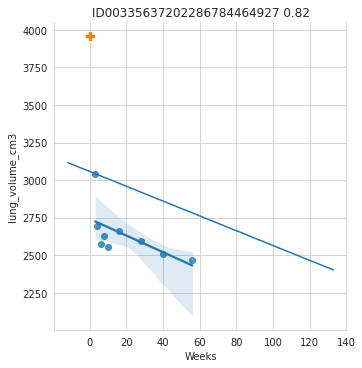

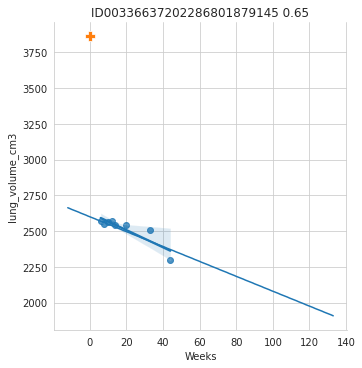

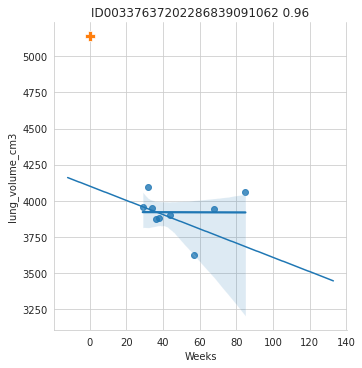

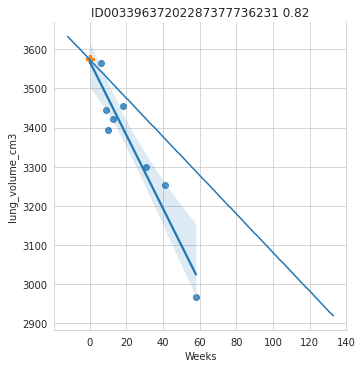

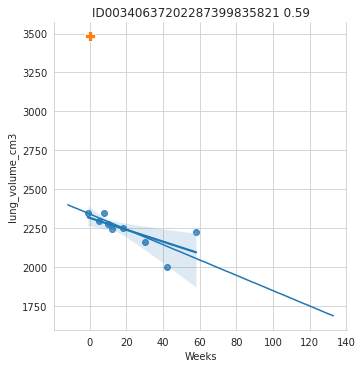

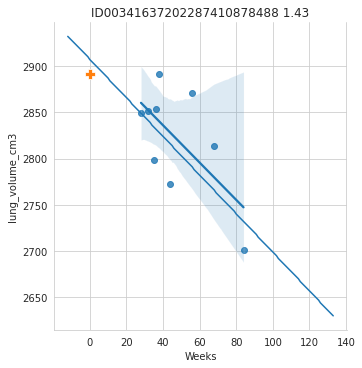

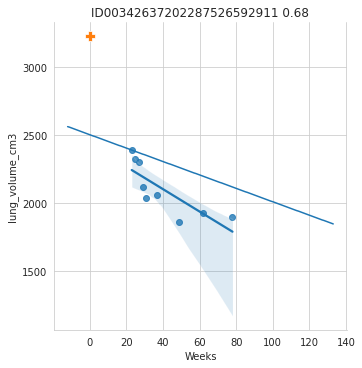

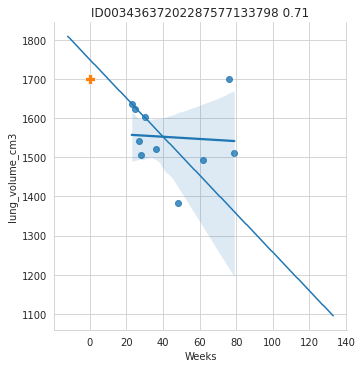

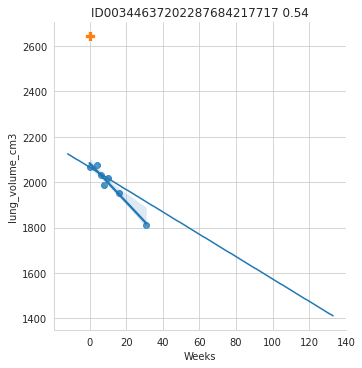

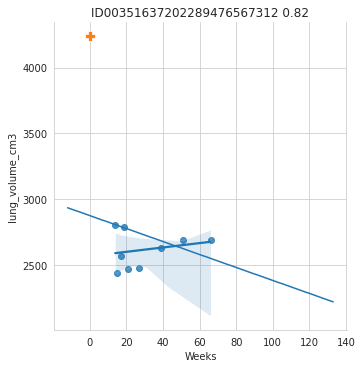

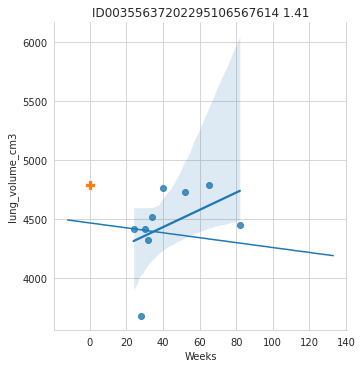

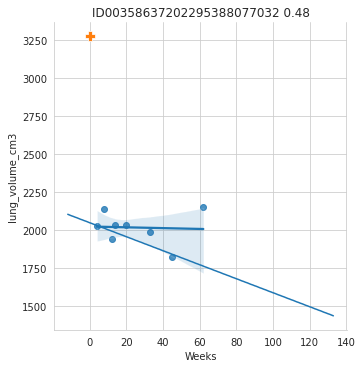

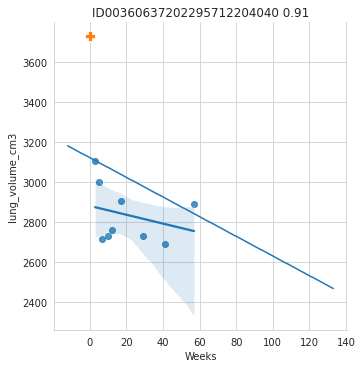

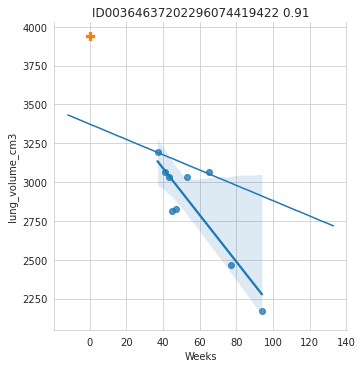

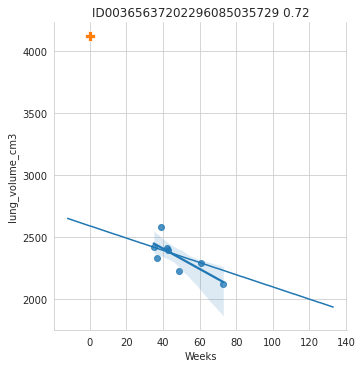

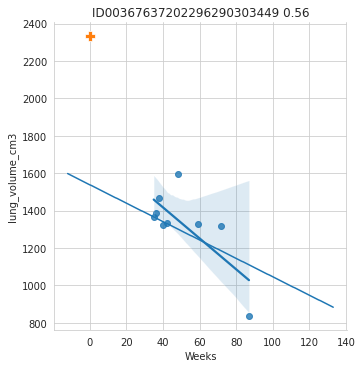

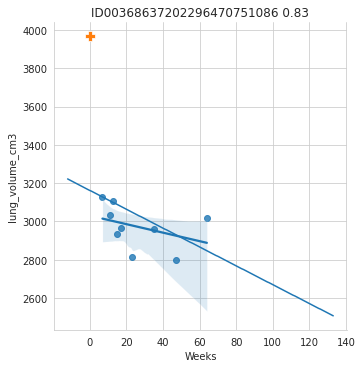

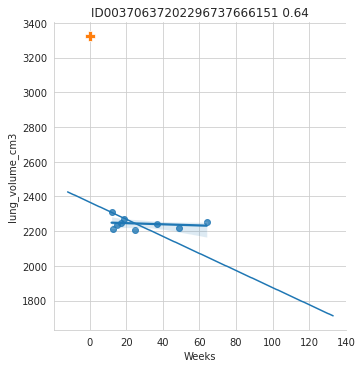

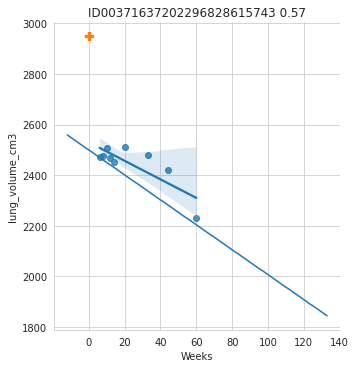

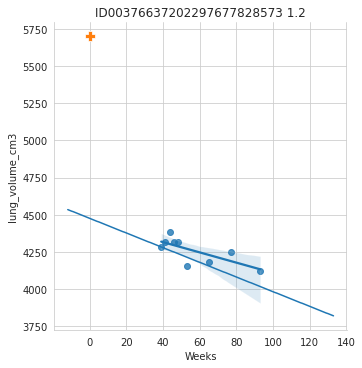

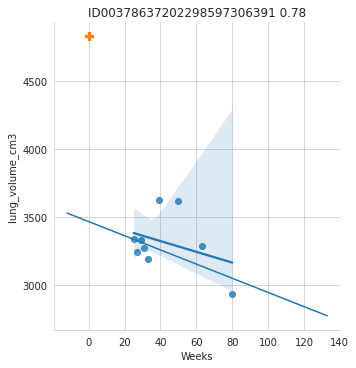

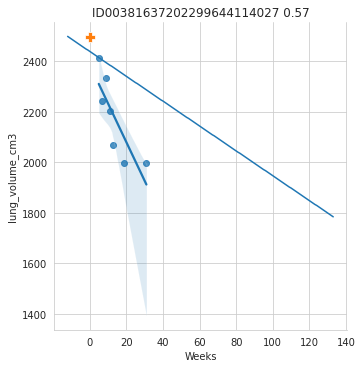

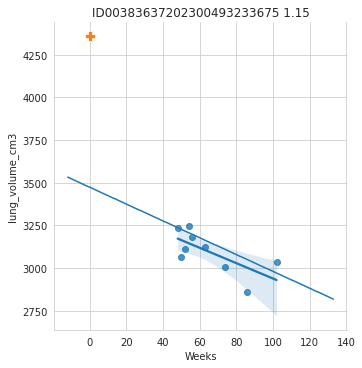

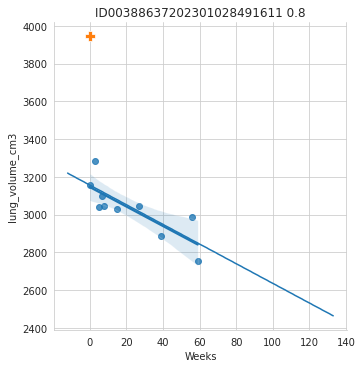

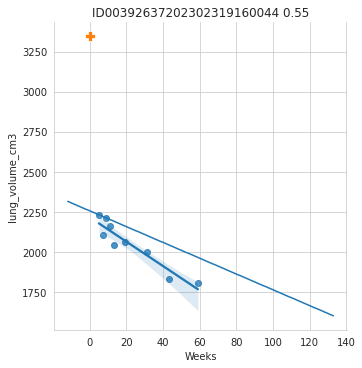

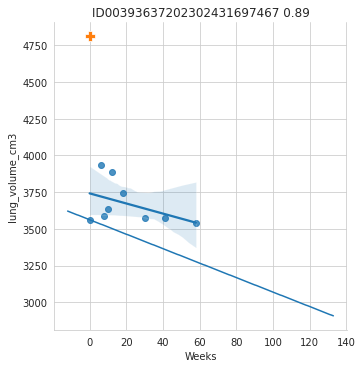

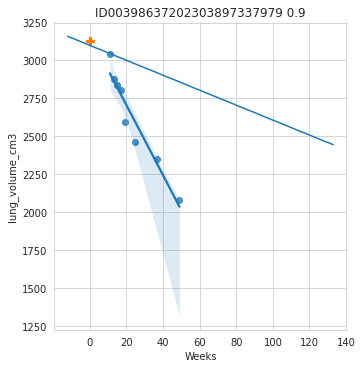

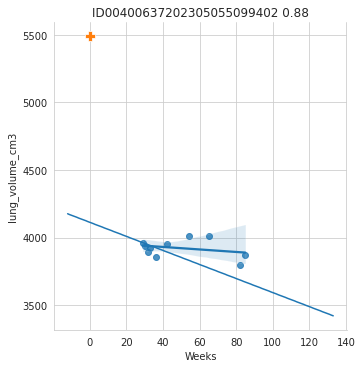

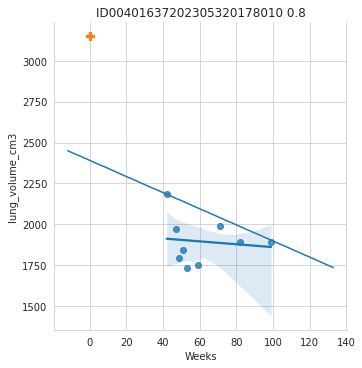

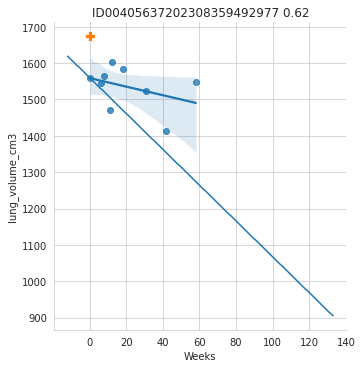

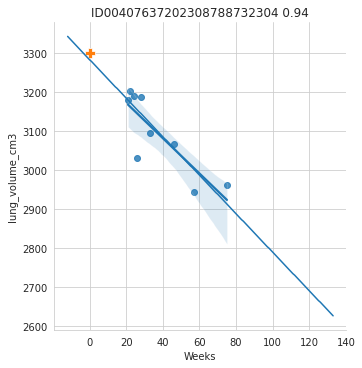

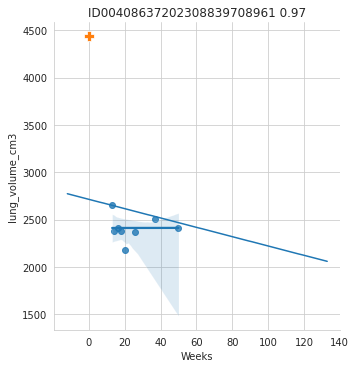

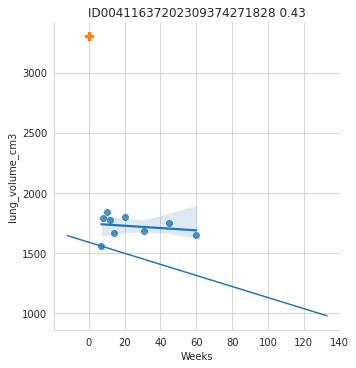

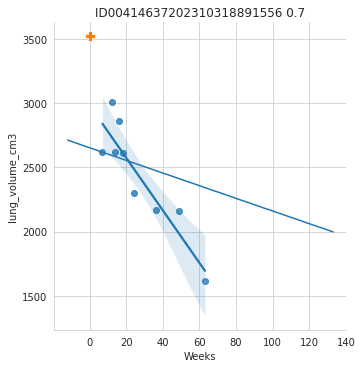

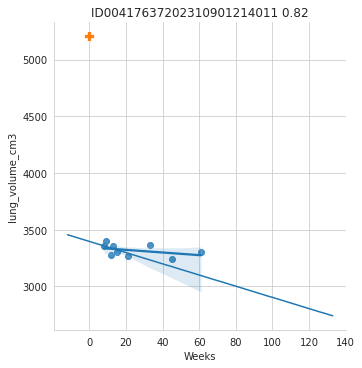

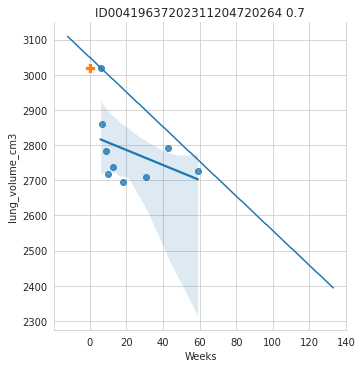

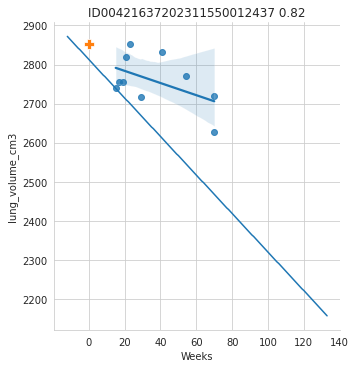

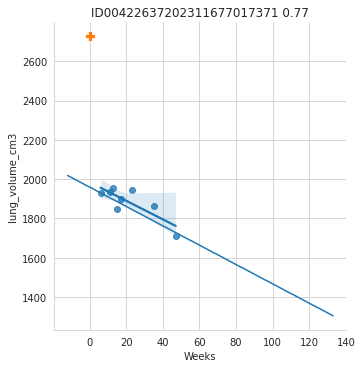

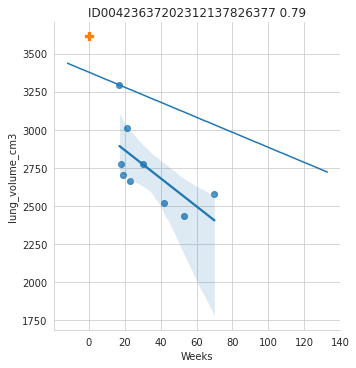

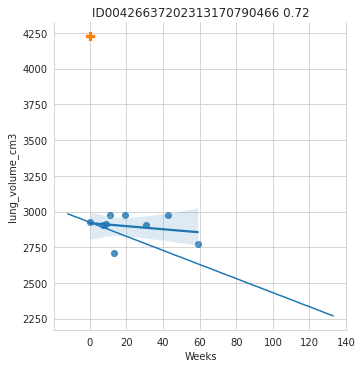

In [1483]:
# p_id = list(df_train_only_first_entry.Patient)
# for patient in p_id:
#     # if df_unique_patients[df_unique_patients.index.str.startswith(patient)]['Gradient_Coef']:
#     #     continue
#     print(patient)
#     lung_volume = df_unique_patients[df_unique_patients.index.str.startswith(patient)]['lung_volume_cm3']
#     # residual_vol_factor = 0.8
#     percent = df_unique_patients[df_unique_patients.index.str.startswith(patient)]['Percent'] / 100
#     # lung_volume = lung_volume * residual_vol_factor * percent
#     x1 = range(-12, 134, 1)
#     y1 = df_submission_train[df_submission_train.Patient_Week.str.startswith(patient)]['FVC'].values
#     y1 = [int(i) for i in y1]
#     sns.lmplot(x = "Weeks", y = "FVC", data = df_train[df_train.Patient == patient])
#     sns.lineplot(x = x1, y = y1)
#     sns.scatterplot(x=[0], y=lung_volume, marker="P", s=100)
#     plt.title(patient + ' ' +str(np.round(percent[0], 2)))
#     plt.show()

